# 0. 本文实现内容
今天我们来实现一个有实际意义的Agent - 实现一个技术文档助手，用户只需要输入技术文档的标题，例如“Git教程”，Agent自动将Git教程写成文档，分目录，分块，条理清晰，并有代码示例。

先看下要实现的效果（全程用户只需要输入“Git 教程”）：

MarkDown格式

分目录，一级标题、二级标题

有代码示例

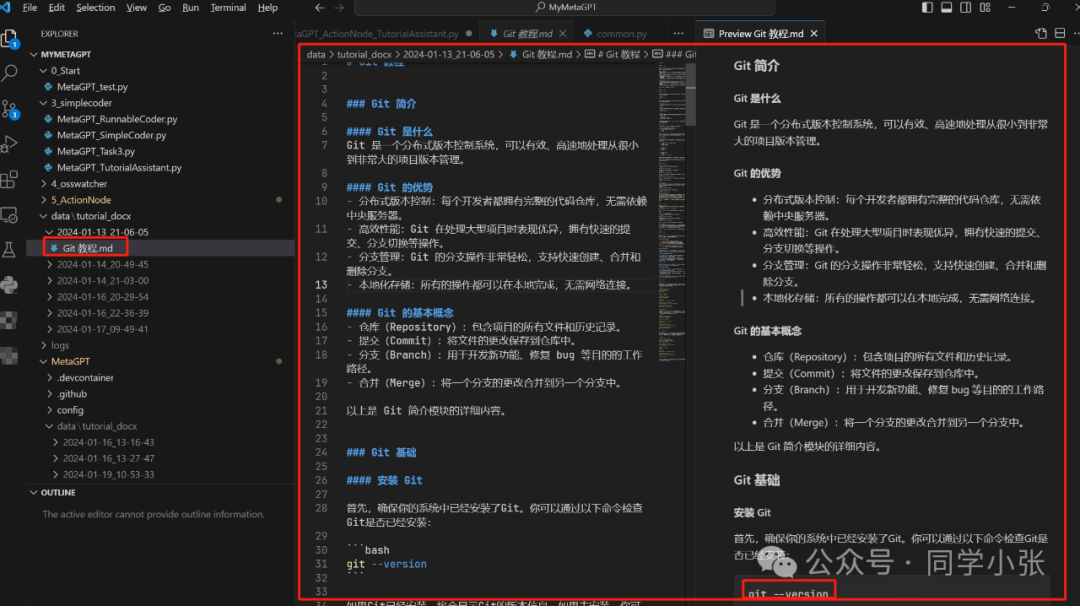

# 1. 实现思路
因为token限制的原因，我们先通过 LLM 大模型生成教程的目录，再对目录按照二级标题进行分块，对于每块目录按照标题生成详细内容，最后再将标题和内容进行拼接，解决 LLM 大模型长文本的限制问题。

整体流程如下（下图来自《MetaGPT智能体开发入门》）：

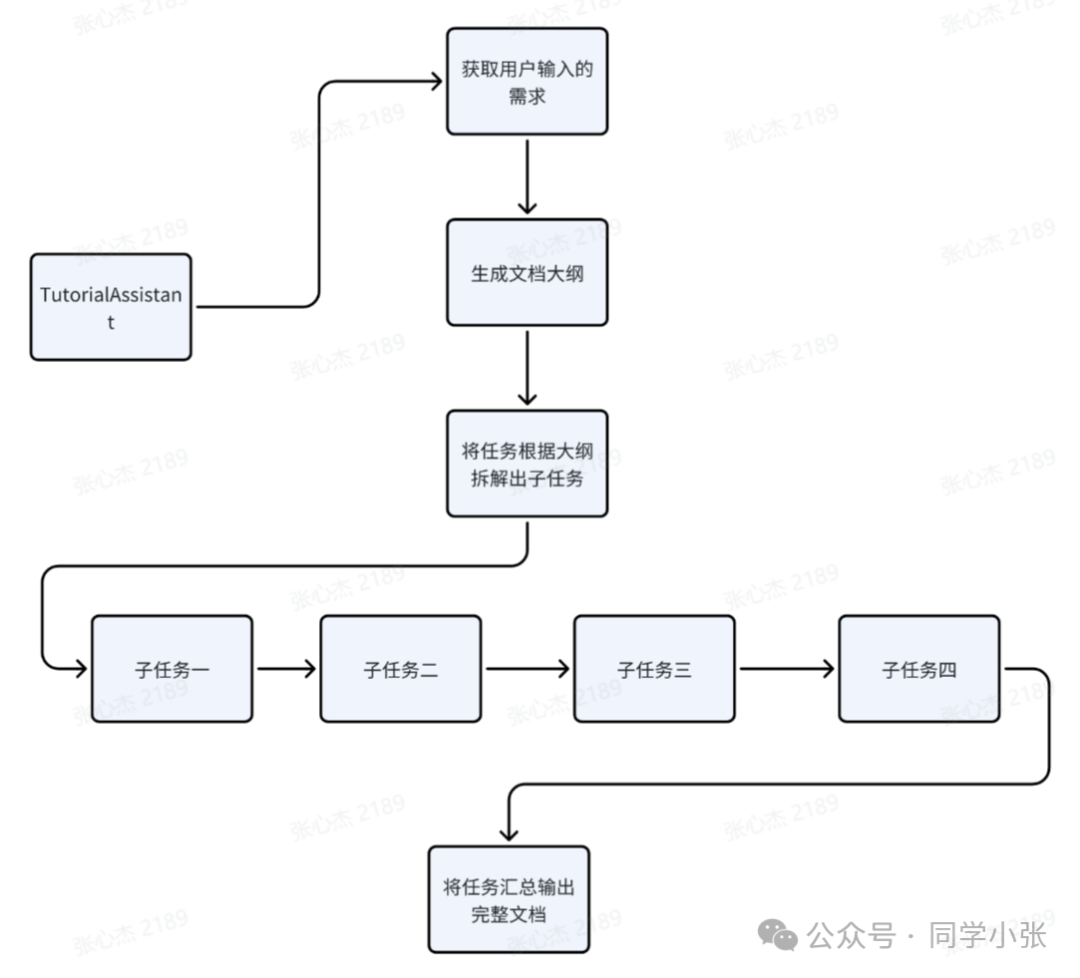

分析上述流程图，我们需要实现：

生成文档大纲的Action：WriteDirectory

子任务的Action：WriteContent

在得到文档大纲之后，要对大纲进行拆分（本例按目录进行拆分），然后根据拆分内容动态添加子任务Action，让子任务去根据目录写技术文档的内容

将子任务Action生成的内容最后做拼接，形成最终的MarkDown文档

# 2. 完整代码及细节注释
直接放出完整代码，代码中添加了一些细节注释来帮助你理解，用的MetaGPT 0.5.2版本。建议你一定要实操一遍，因为不实操，你永远不知道自己会遇到多少坑……

代码并不复杂

WriteDirectory的实现：基本就是我们把自己的需求放入我们准备好的提示词模板里，询问大模型得到结果，然后我们对得到的内容做一个解析。（数据格式化）

WriteContent的实现：直接根据传入的子标题内容调用大模型生成回答

In [ ]:
# 加载 .env 到环境变量
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

from datetime import datetime
from typing import Dict
import asyncio
from metagpt.actions.write_tutorial import WriteDirectory, WriteContent
from metagpt.const import TUTORIAL_PATH
from metagpt.logs import logger
from metagpt.roles import Role
from metagpt.schema import Message
from metagpt.utils.file import File
import fire
import time

from typing import Dict

from metagpt.actions import Action
from metagpt.prompts.tutorial_assistant import DIRECTORY_PROMPT, CONTENT_PROMPT
from metagpt.utils.common import OutputParser

## 1. 生成文档大纲目录
class WriteDirectory(Action):
    """Action class for writing tutorial directories.

    Args:
        name: The name of the action.
        language: The language to output, default is "Chinese".
    """

    def __init__(self, name: str = "", language: str = "Chinese", *args, **kwargs):
        super().__init__(name, *args, **kwargs)
        self.language = language

    async def run(self, topic: str, *args, **kwargs) -> Dict:
        COMMON_PROMPT = """
        You are now a seasoned technical professional in the field of the internet.
        We need you to write a technical tutorial with the topic "{topic}".
        """

        DIRECTORY_PROMPT = COMMON_PROMPT + """
        Please provide the specific table of contents for this tutorial, strictly following the following requirements:
        1. The output must be strictly in the specified language, {language}.
        2. Answer strictly in the dictionary format like {{"title": "xxx", "directory": [{{"dir 1": ["sub dir 1", "sub dir 2"]}}, {{"dir 2": ["sub dir 3", "sub dir 4"]}}]}}.
        3. The directory should be as specific and sufficient as possible, with a primary and secondary directory.The secondary directory is in the array.
        4. Do not have extra spaces or line breaks.
        5. Each directory title has practical significance.
        """
        prompt = DIRECTORY_PROMPT.format(topic=topic, language=self.language)
        resp = await self._aask(prompt=prompt)
        return OutputParser.extract_struct(resp, dict) ## 1.1 对结果进行校验，必须符合Dict结构，否则报错

## 2. 子任务Action，这里是根据拆分的目录标题写技术文档内容
class WriteContent(Action):
    """Action class for writing tutorial content.

    Args:
        name: The name of the action.
        directory: The content to write.
        language: The language to output, default is "Chinese".
    """

    def __init__(self, name: str = "", directory: str = "", language: str = "Chinese", *args, **kwargs):
        super().__init__(name, *args, **kwargs)
        self.language = language
        self.directory = directory

    async def run(self, topic: str, *args, **kwargs) -> str:
        COMMON_PROMPT = """
        You are now a seasoned technical professional in the field of the internet.
        We need you to write a technical tutorial with the topic "{topic}".
        """
        CONTENT_PROMPT = COMMON_PROMPT + """
        Now I will give you the module directory titles for the topic.
        Please output the detailed principle content of this title in detail.
        If there are code examples, please provide them according to standard code specifications.
        Without a code example, it is not necessary.

        The module directory titles for the topic is as follows:
        {directory}

        Strictly limit output according to the following requirements:
        1. Follow the Markdown syntax format for layout.
        2. If there are code examples, they must follow standard syntax specifications, have document annotations, and be displayed in code blocks.
        3. The output must be strictly in the specified language, {language}.
        4. Do not have redundant output, including concluding remarks.
        5. Strict requirement not to output the topic "{topic}".
        """
        prompt = CONTENT_PROMPT.format(
            topic=topic, language=self.language, directory=self.directory)
        return await self._aask(prompt=prompt)

## 3. 技术文档角色，用来执行Action
class TutorialAssistant(Role):
    def __init__(
        self,
        name: str = "Stitch",
        profile: str = "Tutorial Assistant",
        goal: str = "Generate tutorial documents",
        constraints: str = "Strictly follow Markdown's syntax, with neat and standardized layout",
        language: str = "Chinese",
    ):
        super().__init__(name, profile, goal, constraints)
        self._init_actions([WriteDirectory(language=language)]) ## 3.1 初始化时，先只添加WriteDirectory Action，生成目录。WriteContent Action后面根据目录动态添加，这里你也不知道要添加多少个，添加的内容是什么。
        self.topic = ""
        self.main_title = "" ## 3.2 记录文章题目
        self.total_content = "" ## 3.3 生成的所有内容，拼接到这里
        self.language = language

    async def _think(self) -> None:
        """Determine the next action to be taken by the role."""
        if self._rc.todo is None:
            self._set_state(0) ## 3.4 转到第一个Action执行
            return

        if self._rc.state + 1 < len(self._states):
            self._set_state(self._rc.state + 1) ## 3.5 将要执行下一个Action
        else:
            self._rc.todo = None

    ## 3.6 根据生成的目录，拆分出一级标题和二级标题，动态添加到WriteContent Action中，输入的titles必须是Dict类型，这就要求WriteDirectory的输出必须能按Dict类型解析，否则报错，程序无法继续执行。
    async def _handle_directory(self, titles: Dict) -> Message:
        self.main_title = titles.get("title")
        directory = f"{self.main_title}\n"
        self.total_content += f"# {self.main_title}"
        actions = list()
        for first_dir in titles.get("directory"):
            actions.append(WriteContent(
                language=self.language, directory=first_dir)) ## 3.7 动态添加 WriteContent Action，将一级目录内容传入
            key = list(first_dir.keys())[0]
            directory += f"- {key}\n"
            for second_dir in first_dir[key]:
                directory += f"  - {second_dir}\n"
        self._init_actions(actions) ## 3.8 执行了这一句，此时动作列表全是WriteContent了
        self._rc.todo = None
        return Message(content=directory)

    async def _act(self) -> Message:
        """Perform an action as determined by the role.

        Returns:
            A message containing the result of the action.
        """
        time.sleep(20) ## 3.9 这是为了避免OpenAI接口调用频率限制，不是办法的办法
        todo = self._rc.todo
        if type(todo) is WriteDirectory:
            msg = self._rc.memory.get(k=1)[0] ## 3.10 获取记忆，这里是获取用户输入，因为任何动作都还没执行，所以只有用户输入
            self.topic = msg.content
            resp = await todo.run(topic=self.topic) ## 3.11 根据用户输入生成目录
            logger.info(resp)
            return await self._handle_directory(resp)
        resp = await todo.run(topic=self.topic) ## 3.12 走到这里的都是WriteContent Action。 这里的self.topic还是用户输入，因为并没有其它地方更新该值。这里传入的目的是让WriteContent写的内容以这个为范围限制
        logger.info(resp)
        if self.total_content != "":
            self.total_content += "\n\n\n"
        self.total_content += resp ## 3.13 拼接数据
        return Message(content=resp, role=self.profile)

    async def _react(self) -> Message:
        """Execute the assistant's think and actions.

        Returns:
            A message containing the final result of the assistant's actions.
        """
        while True:
            await self._think()
            if self._rc.todo is None:
                break
            msg = await self._act()

        ## 3.14 全部Action执行完毕，写文件
        root_path = TUTORIAL_PATH / datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        await File.write(root_path, f"{self.main_title}.md", self.total_content.encode('utf-8'))
        return msg

async def main():
    msg = "Git 教程"
    role = TutorialAssistant()
    logger.info(msg)
    result = await role.run(msg)
    logger.info(result)

asyncio.run(main())